# AUTOENCODER TRAINING

### Imports

In [1]:
import gc
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.api.callbacks import EarlyStopping
from keras.api.layers import Conv2D, Input, MaxPooling2D, UpSampling2D
from sklearn.model_selection import KFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from keras.api.models import Model
from keras.api.utils import plot_model

# Directories
DATA_DIR = "../../data"
AUDIOS_DIR = DATA_DIR + "/audios"
POS_AUDIOS_DIR = AUDIOS_DIR + "/positive"
NEG_AUDIOS_DIR = AUDIOS_DIR + "/negative"

MODELS_DIR = "../../models"
PLOTS_DIR = "../../plots"

### Feature Extraction selection

In [2]:
FEATURE = "chroma"  # 'mfcc', 'chroma', 'lfcc'

### Getting data

In [3]:
with open(f"{DATA_DIR}/{FEATURE}.pkl", "rb") as f:
    data = pickle.load(f)

# Positive data
positive_data = np.array(data["positive"])
positive_labels = np.ones(positive_data.shape[0])
pnames = data["pnames"]

# Negative data
negative_data = np.array(data["negative"])
negative_labels = np.zeros(negative_data.shape[0])
nnames = data["nnames"]

# Concatenate the data
X = np.concatenate((positive_data, negative_data), axis=0)
y = np.concatenate((positive_labels, negative_labels), axis=0)
names = np.concatenate((pnames, nnames), axis=0)

# Establecer la semilla aleatoria
seed = 1  # Elige cualquier número entero como semilla
rng = np.random.default_rng(seed)

# Shuffle the data using the random number generator
idx = rng.permutation(len(X))

X = X[idx]
y = y[idx]
names = names[idx]

In [4]:
# Funciones auxiliares
def normalize(X):
    return (X - np.mean(X)) / np.std(X)


def sub_extra_column(X):
    return X[:, :, :-1]


def transpose(X):
    return X.transpose(0, 2, 1)


# Definición del pipeline
preprocessing_pipeline = Pipeline(
    [
        ("normalize", FunctionTransformer(normalize, validate=False)),  # Normalización
        ("scale", MinMaxScaler(feature_range=(0, 1))),  # Escalado
        (
            "sub_column",
            FunctionTransformer(sub_extra_column, validate=False),
        ),  # Quitar columna
        ("transpose", FunctionTransformer(transpose, validate=False)),  # Transponer
    ]
)


# Aplicar el pipeline
def process_and_encode(X, encoder=None):
    # Reshape para MinMaxScaler (flatten y restaurar)
    X = preprocessing_pipeline.named_steps["normalize"].transform(X)
    X = (
        preprocessing_pipeline.named_steps["scale"]
        .fit_transform(X.reshape(X.shape[0], -1))
        .reshape(X.shape)
    )
    X = preprocessing_pipeline.named_steps["sub_column"].transform(X)
    X = preprocessing_pipeline.named_steps["transpose"].transform(X)

    # Predicción con el encoder
    if encoder is not None:
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
        XC = encoder.predict(X)
        return XC
    return X


X = process_and_encode(X)
print(X.shape)
print(X)

(10000, 312, 12)
[[[0.6625104  0.7131241  0.54913056 ... 0.93006504 1.         0.7376822 ]
  [0.10070452 0.09331521 0.18232629 ... 0.34380862 1.         0.33292744]
  [0.02802193 0.04405317 0.13445559 ... 0.31337768 1.         0.20779368]
  ...
  [0.00223351 0.00757784 0.02539572 ... 0.03620121 0.00753585 0.00398862]
  [0.01388285 0.02910209 0.05700171 ... 0.05910316 0.02055958 0.01457372]
  [0.11985928 0.24983719 0.14913785 ... 0.15053365 0.15389518 0.09123695]]

 [[0.55240846 0.8065884  0.7031232  ... 0.38153768 0.47513098 0.5483687 ]
  [0.85081947 1.         0.73308754 ... 0.34604752 0.5838492  0.7697251 ]
  [1.         0.99847305 0.61514544 ... 0.31203488 0.6148981  0.8432033 ]
  ...
  [0.6610652  1.         0.8221686  ... 0.2519225  0.28791872 0.38545147]
  [0.61234504 0.9828687  1.         ... 0.3511635  0.30056202 0.28088728]
  [0.5812986  0.9147285  1.         ... 0.32631013 0.216595   0.23766963]]

 [[0.09524044 0.1390887  0.5288943  ... 0.16679119 0.0839462  0.25017372]
  [0.

In [ ]:
def AUTOENCODER(latent_size=78):
    input_img = Input(shape=(X.shape[1], X.shape[2], 1))

    # Encoder
    x = Conv2D(1, (3, 3), activation="sigmoid", padding="same")(input_img)
    # Primera reducción: siempre se aplica para pasar de 312 a 156 (si se desea 156 o menos)
    x = MaxPooling2D((2, 1), padding="same")(x)  # Resultado: 156x12

    if latent_size <= 78:
        x = Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)
        x = MaxPooling2D((2, 1), padding="same")(x)  # Resultado: 78x12
    if latent_size == 26:
        x = Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)
        x = MaxPooling2D((3, 1), padding="same")(x)  # Resultado: 26x12
    if latent_size == 39:
        x = Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)
        x = MaxPooling2D((2, 1), padding="same")(x)  # Resultado: 39x12

    encoded = x

    # Decoder: Se debe construir de forma que revierta la reducción aplicada en el encoder

    if latent_size == 39:
        x = UpSampling2D((2, 1))(encoded)
        x = Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)
    if latent_size == 26:
        x = UpSampling2D((3, 1))(encoded)
        x = Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)
    if latent_size <= 78:
        x = UpSampling2D((2, 1))(x)
        x = Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)
    # Para el caso de latent_size == 156 o tras la última operación
    x = UpSampling2D((2, 1))(x)
    decoded = Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

    model = Model(input_img, decoded)
    model.compile(optimizer="adam", loss="mse", metrics=["mse"])

    # Modelo encoder
    encoder = Model(input_img, encoded, name="encoder")
    encoder.compile(optimizer="adam", loss="mse", metrics=["mse"])

    return model, encoder


model, encoder = AUTOENCODER()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 312, 12, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 312, 12, 1)     │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 156, 12, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 156, 12, 1)     │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 78, 12, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 78, 12, 1)      │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 26, 12, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 78, 12, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 78, 12, 1)      │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 156, 12, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 156, 12, 1)     │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 312, 12, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 312, 12, 1)     │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60 (240.00 B)

 Trainable params: 60 (240.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import visualkeras

img = visualkeras.layered_view(
    model,
    to_file='autoencoder_visualkeras.png',
    scale_xy=10,
    scale_z=100,
    draw_volume=True,
    legend=True,
)

img.save('autoencoder.png', dpi=(3000, 3000))

In [ ]:
trn_size = 0.8
tst_size = 1 - trn_size

print(X.shape)
print(y.shape)

X_train, X_tst, y_train, y_tst, idxtrn, idxtst = train_test_split(
    X,
    y,
    np.arange(len(X)),
    train_size=trn_size,
    test_size=tst_size,
    stratify=y,
    random_state=seed,
)

# Mantener los nombres de los audios
names = np.array(names)
namestrn = names[idxtrn]
namestst = names[idxtst]

print(X_train.shape)
print(y_train.shape)
print(X_tst.shape)
print(y_tst.shape)

(10000, 312, 12)
(10000,)
(8000, 312, 12)
(8000,)
(2000, 312, 12)
(2000,)



Entrenando para tamaño 78

Fold 1
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 0.0183 - mse: 0.0183 - val_loss: 0.0173 - val_mse: 0.0173
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0169 - mse: 0.0169 - val_loss: 0.0161 - val_mse: 0.0161
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0158 - mse: 0.0158 - val_loss: 0.0148 - val_mse: 0.0148
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0144 - mse: 0.0144 - val_loss: 0.0136 - val_mse: 0.0136
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0133 - mse: 0.0133 - val_loss: 0.0128 - val_mse: 0.0128
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0127 - mse: 0.0127 - val_loss: 0.0123 - val_mse: 0.0123
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0119 - mse: 0.0119 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0109 - val_mse: 0.0109
Epoch 9/200
50/50 ━━━

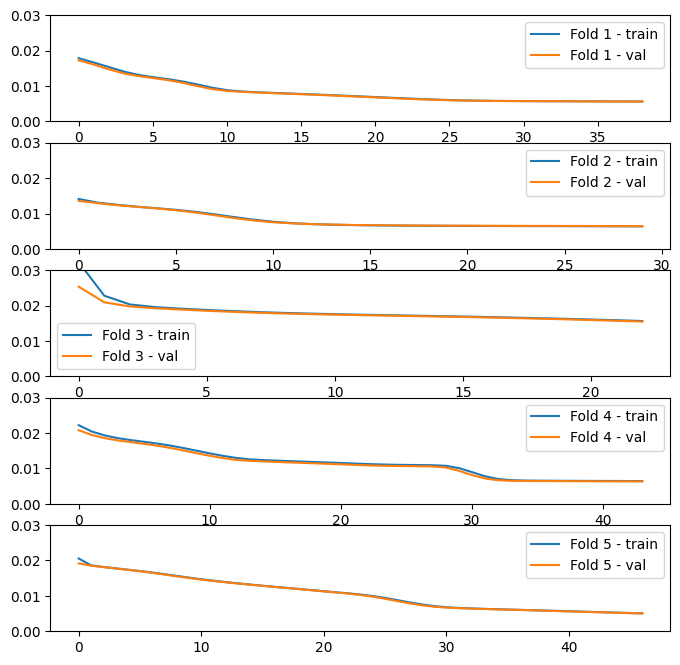

In [ ]:
percent = 0.5
sizes = [78]
k = 5  # Número de particiones para cross-validation
kf = KFold(n_splits=k, shuffle=True, random_state=seed)

# Crear una figura para agrupar todas las curvas
for size in sizes:
    cv_val_losses = []  # Lista para almacenar las pérdidas de validación en cada fold
    print(f"\nEntrenando para tamaño {size}")

    fold = 1
    plt.figure(figsize=(8, 8))
    for train_idx, val_idx in kf.split(X_train):
        print(f"\nFold {fold}")
        X_train_cv, X_val_cv = X_train[train_idx], X_train[val_idx]

        # Usar solo el primer 10% de X_train_cv para entrenar
        X_train_cv = X_train_cv[: int(len(X_train_cv) * percent)]

        early_stopping = EarlyStopping(
            monitor="val_loss", patience=20, min_delta=0.005, restore_best_weights=True
        )

        # Crear el modelo con el tamaño latente actual
        model, encoder = AUTOENCODER(size)

        # Entrenar el modelo usando parte de X_train para validación
        history_cv = model.fit(
            X_train_cv,
            X_train_cv,
            validation_data=(X_val_cv, X_val_cv),
            epochs=200,
            batch_size=64,
            verbose=1,
            callbacks=[early_stopping],
        )

        # Obtener la pérdida en validación del último epoch
        fold_val_loss = history_cv.history["val_loss"][-1]
        cv_val_losses.append(fold_val_loss)
        print(f"Fold {fold} - Pérdida de validación: {fold_val_loss}")

        # Plot training and validation loss for the current fold
        # in grid, each fold in a cell
        plt.subplot(k, 1, fold)
        plt.plot(history_cv.history["loss"], label=f"Fold {fold} - train")
        plt.plot(history_cv.history["val_loss"], label=f"Fold {fold} - val")
        plt.ylim(0, 0.03)
        plt.legend()

        fold += 1

        # Liberar recursos de memoria
        tf.keras.backend.clear_session()
        gc.collect()

    avg_val_loss = np.mean(cv_val_losses)
    print(f"Tamaño {size}: Pérdida de validación promedio = {avg_val_loss}")

    # Mostrar plot con curvas de entrenamiento y validación
    plt.savefig(f"{PLOTS_DIR}/ae-{size}-{FEATURE}.png")
    plt.show()


In [ ]:
# Entrenar modelo final con el tamaño latente óptimo
model, encoder = AUTOENCODER(78)
early_stopping = EarlyStopping(
    monitor="loss", patience=20, min_delta=0.005, restore_best_weights=True
)

history = model.fit(
    X_train, X_train, epochs=200, batch_size=64, verbose=1, callbacks=[early_stopping]
)

Epoch 1/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 0.0493 - mse: 0.0493
Epoch 2/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0200 - mse: 0.0200
Epoch 3/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0165 - mse: 0.0165
Epoch 4/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0156 - mse: 0.0156
Epoch 5/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0152 - mse: 0.0152
Epoch 6/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0147 - mse: 0.0147
Epoch 7/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0142 - mse: 0.0142
Epoch 8/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0138 - mse: 0.0138
Epoch 9/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0133 - mse: 0.0133
Epoch 10/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0132 - mse: 0.0132
Epoch 11/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0129 - mse: 0.0129
Epoch 12/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0128 - mse: 0.0128
E

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
Nombre del audio: 1-Emergency_vehicle-kVprQacUYrI.wav


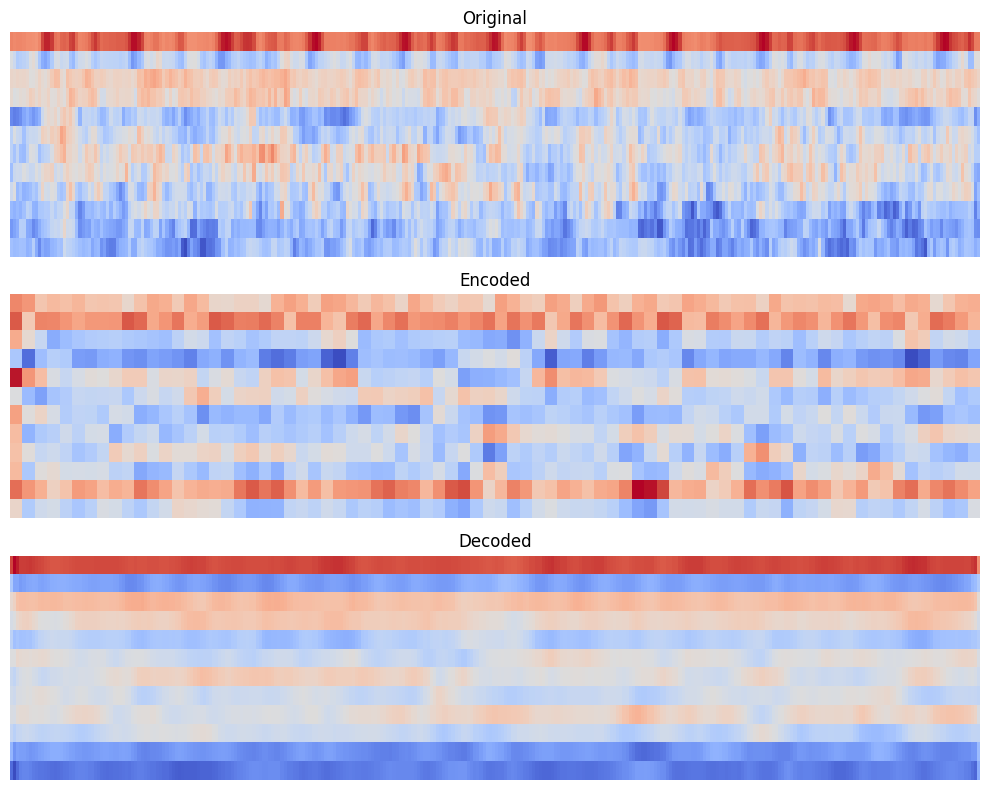

In [ ]:
# Comprobar una imagen y su reconstruccion
idx = 101
X_test = X_tst[idx : idx + 1]
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
X_test_encoded = encoder.predict(X_test)
X_test_decoded = model.predict(X_test)

# Rotate 90 degrees
X_test = np.rot90(X_test, 3, (1, 2))
X_test_encoded = np.rot90(X_test_encoded, 3, (1, 2))
X_test_decoded = np.rot90(X_test_decoded, 3, (1, 2))

# Invertir valores encoded
# X_test_encoded = 1 - X_test_encoded

# Print del nombre del audio
print(f"Nombre del audio: {namestst[idx]}")

# Visualizar la imagen original y la reconstrucción
plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 1)
plt.imshow(X_test[0, :, :, 0], cmap="coolwarm", aspect="auto")
plt.title("Original")
plt.axis("off")
plt.subplot(3, 1, 2)
plt.imshow(X_test_encoded[0, :, :, 0], cmap="coolwarm", aspect="auto")
plt.title("Encoded")
plt.axis("off")
plt.subplot(3, 1, 3)
plt.imshow(X_test_decoded[0, :, :, 0], cmap="coolwarm", aspect="auto")
plt.title("Decoded")
plt.axis("off")
plt.tight_layout()
plt.show()


In [25]:
# Evaluar conjunto de test
X_test = X_tst
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
X_test_decoded = model.evaluate(X_test, X_test, batch_size=64, verbose=1)
print(f"Test loss: {X_test_decoded[0]}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0075 - mse: 0.0075
Test loss: 0.007504918146878481


In [ ]:
# Guardar el modelo encoder
if not os.path.exists(f"{MODELS_DIR}/encoders"):
    os.makedirs(f"{MODELS_DIR}/encoders")
encoder.save(f"{MODELS_DIR}/encoders/encoder_{FEATURE}_78.keras")